# Predicting Stock Market Prices

The stock market works through a network of exchanges(eg.NewYork Stock Exchange).It is similar to a auction house where buyers and sellers negotiate prices and make trades.

Some companies are publically traded which means that anyone can buy and sell their shares in the open market.A share entitles the owner some control over the direction and share of the earnings of the company.When you buy or sell shares it is commonly known as trading a stock.The price of a share is primarily based on supply and demand of a given stock.Stocks are traded daily and the price can rise or fall from the beginning of a trading day to the end based on demand.Indexes aggregate the prices of multiple stocks together, and allow you to see how the market as a whole performs.

The [S&P500 Index](https://www.investopedia.com/terms/s/sp500.asp) aggregates the stock prices of 500 large companies. When an index fund goes up or down, you can say that the primary market or sector it represents is doing the same.We will be workig with historical data on the price of the S&P500 Index to make predictions about future prices. We will be predicting the **closing prices** of the stock using a time series model.

In [1]:
#Importing required libraries
import pandas as pd
data=pd.read_csv("sphist.csv",parse_dates=["Date"],index_col="Date")  # For a ts object we need the dates as index
data.head()

Open         High          Low        Close        Volume  \
Date                                                                           
2015-12-07  2090.419922  2090.419922  2066.780029  2077.070068  4.043820e+09   
2015-12-04  2051.239990  2093.840088  2051.239990  2091.689941  4.214910e+09   
2015-12-03  2080.709961  2085.000000  2042.349976  2049.620117  4.306490e+09   
2015-12-02  2101.709961  2104.270020  2077.110107  2079.510010  3.950640e+09   
2015-12-01  2082.929932  2103.370117  2082.929932  2102.629883  3.712120e+09   

              Adj Close  
Date                     
2015-12-07  2077.070068  
2015-12-04  2091.689941  
2015-12-03  2049.620117  
2015-12-02  2079.510010  
2015-12-01  2102.629883

The columns of the dataset are as below:

| Column     	| Description                                                                                          	|
|------------	|------------------------------------------------------------------------------------------------------	|
| Date       	|  The   date of the record.                                                                           	|
| Open       	|  The opening price of the day (when   trading starts).                                               	|
| High       	|  The highest trade price during the   day.                                                           	|
| Low        	|  The lowest trade price during the   day.                                                            	|
| Close      	|  The closing price for the day   (when trading is finished).                                         	|
| Volume     	|  The number of shares traded.                                                                        	|
| Adj Close  	|  The daily closing price, adjusted   retroactively to include any corporate actions. Read more [here](http://www.investopedia.com/terms/a/adjusted_closing_price.asp).|


In [2]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [3]:
data.describe()

Open          High           Low         Close        Volume  \
count  16590.000000  16590.000000  16590.000000  16590.000000  1.659000e+04   
mean     482.570941    485.624237    479.367501    482.692491  7.940099e+08   
std      554.889186    558.186049    551.367625    555.007904  1.456582e+09   
min       16.660000     16.660000     16.660000     16.660000  6.800000e+05   
25%       83.860001     84.594997     83.139997     83.860001  7.610000e+06   
50%      144.049996    145.294998    143.105004    144.264999  7.170500e+07   
75%      950.722488    956.665024    941.969986    950.797500  7.866750e+08   
max     2130.360107   2134.719971   2126.060059   2130.820068  1.145623e+10   

          Adj Close  
count  16590.000000  
mean     482.692491  
std      555.007904  
min       16.660000  
25%       83.860001  
50%      144.264999  
75%      950.797500  
max     2130.820068

In [4]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

Now that we have loaded the data and checked for missing values and we have none so we will be moving ahead with the analysis.
We will first start with visualizing the patterns in closing price.

In [5]:
# Select only the Close  column from the dataframe

ts=data["Close"].sort_index()  # Sort the data so that it appears as per date
ts.index.dtype

dtype('<M8[ns]')

# Visualize Patterns In Closing Price

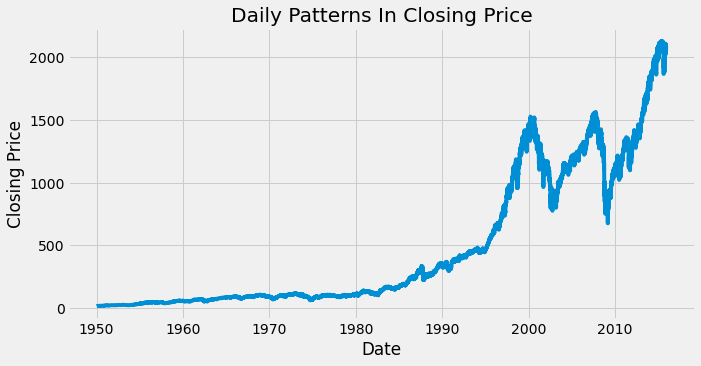

In [6]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use("fivethirtyeight")
plt.figure(figsize=(10,5))
plt.plot(ts)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Daily Patterns In Closing Price")
plt.show()

# Checking Stationarity of Time Series
A time series majorly consists of four components:
1. Level - Avg Value of the series
2. Trend - Linearity of the series(increasing or decreasing with time)
3. Seasonal - Repetitive patterns(rise or fall) at regular intervals
4. Noise - Random variations in the series

Before we dive into any analysis it is necessary to check if the series is stationary or not. A series is stationary if its mean and variance remain constant over time.It is important to check this because most of the time series models work on the assumption that underlying time series is stationary.

From the above plot we can clearly see a increasing trend meaning the series is not stationary. However we will not always be able to make visual inferences.So formally we can check for stationarity using below methods:

1. Plotting Rolling Statistics - Plot moving average or moving variance and check if if varies with time.
2. Dicky-Fuller Test - This is a statistical test with the null hypothesis that series is not stationary.


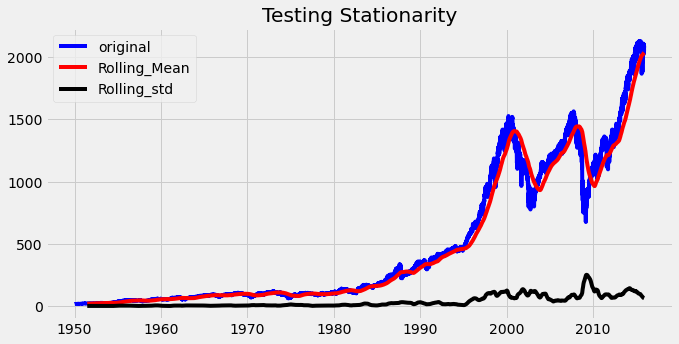

In [7]:
#Create a function to Plot rolling statistics

def test_stationarity(timeseries,ma_param): # Function takes in a timeseries and moving avg window
    '''
    Calculate rolling statistics - mean and standard deviation and plot it against actuals'''
    rol_mean=timeseries.rolling(ma_param).mean()
    rol_std=timeseries.rolling(ma_param).std()
    style.use("fivethirtyeight")
    plt.figure(figsize=(10,5))
    plt.plot(timeseries,color="blue",label="original")
    plt.plot(rol_mean,color="red",label="Rolling_Mean")
    plt.plot(rol_std,color="black",label="Rolling_std")
    plt.title("Testing Stationarity")
    plt.legend()
    plt.show()
    
    
test_stationarity(ts,365)     #365 because we have daily data.

From the above graph we can see that the mean and standard deviation are increasing with time and are not constant.Hence our series is not stationary.

In [8]:
# Using Dicky Fuller Test to test stationarity
from statsmodels.tsa.stattools import adfuller

adft=adfuller(ts,autolag="AIC")  # Instead of passing the number of lags we pas autolag=AIC so that the model considers the no
                                 #lags that yield minimum AIC

adft

(1.84897322545978,
 0.9984413578754435,
 43,
 16546,
 {'1%': -3.430745280720123,
  '5%': -2.8617146981771375,
  '10%': -2.5668629874150324},
 115614.4133752372)

In [9]:
'''
From the above we can see that interpreting the result is difficult because of lack of nomenclature.
Let's try to print the output along with names so that it is easy to interpret'''

print(f'ADF Statistic : {adft[0]}')  # Print the test statistic 
''' A formatted string literal or f-string is a string literal that is prefixed with 'f' or 'F'. 
These strings may contain replacement fields, which are expressions delimited by curly braces {}.
While other string literals always have a constant value,formatted strings are really expressions evaluated at run time.'''

print(f'p_value : {adft[1]}')

print(f'n_lags : {adft[2]}')

print(f'no_of_obs {adft[3]}')

for key,value in adft[4].items():
    print("Critical Values")
    print(f' {key},{value}')

ADF Statistic : 1.84897322545978
p_value : 0.9984413578754435
n_lags : 43
no_of_obs 16546
Critical Values
 1%,-3.430745280720123
Critical Values
 5%,-2.8617146981771375
Critical Values
 10%,-2.5668629874150324


From the above we can see:
1. The p_value is greater than level of significance 0.05.
2. The ADF test statistic is greater than any of the critical values.

Hence there is no reason to believe that null hypotheses should be rejected. Hence the series is non stationary.

# Converting the series to stationary

Now that we know our time series is not stationary we need to convert it to a stationary one so that we can fit time series models to the same.

There are two major reasons which make the time series non stationary:

1. Trend - Varying the means with respect to time
2. Seasonality - Varying the variations at certain timeframes.

The concept to make a series stationary is to essentially model the trend and sesonality and then remove them from the series so that statistical forecasting methods can be applied to those. Once predictions are done we can add those trend and seasonality constraints back to the forecasted values.

## Removing Trend

To remove the trend the first thing which we can consider is transforming the data and then taking a moving average.

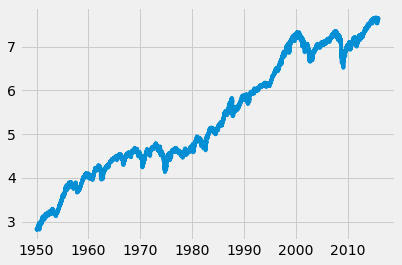

In [10]:
import numpy as np
ts_log=np.log(ts)  #log transform the series
plt.plot(ts_log)
plt.show()

From the above graph it is evident that the time series shows a linear trend.However this might not be the case always.
We will now try to model this increasing test using moving average method.We will go ahead with **weighted moving average** so that more recent values get higher weight.

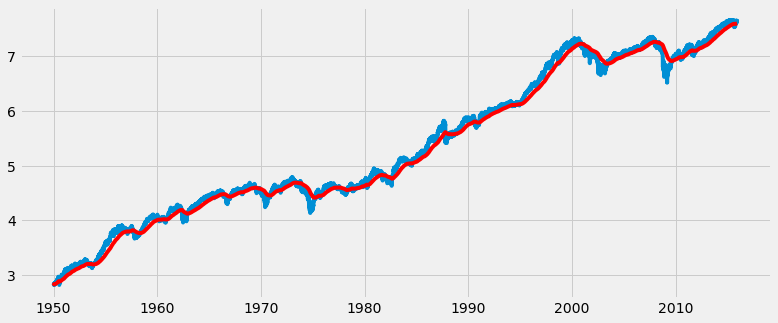

In [11]:
plt.figure(figsize=(12,5))
expwighted_avg = ts_log.ewm(span=365).mean()  # 365 because we have daily data
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

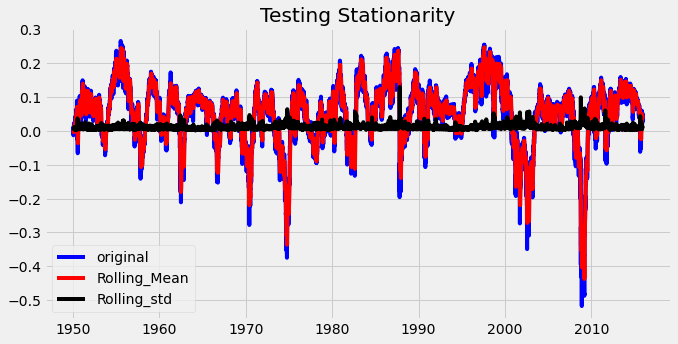

In [12]:
st_ts=ts_log-expwighted_avg
st_ts.dropna(inplace=True)
test_stationarity(st_ts,12)

## Eliminate Trend and Seasonality

The above technique of getting rid of trend has worked pretty well to make series stationary but will not work always specially when we have highly seasonal data. Hence we need to think of techniques which will take care of both seasonality and trend.

We have two ways of doing so:
1. Differencing - Differencing the time series with a particular lag
2. Decomposition - Decomposing the trend and seasonal components and modelling them both.

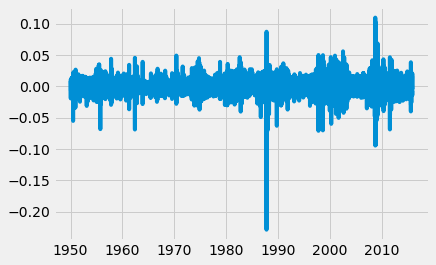

In [13]:
# Differencing
ts_log_diff=ts_log-ts_log.shift()  #difference of the obs with the previous obs
plt.plot(ts_log_diff)

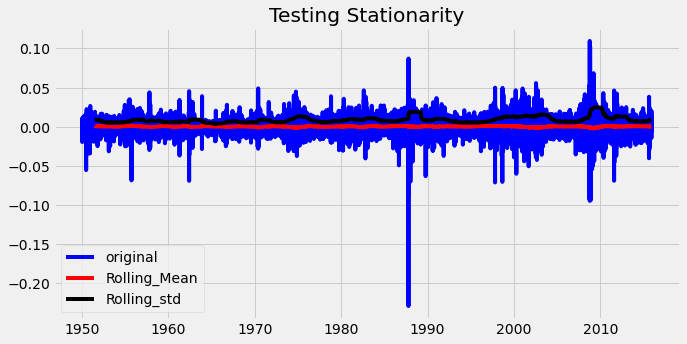

In [14]:
#The trend has reduced significantly. Let's confirm with our plots
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff,365)

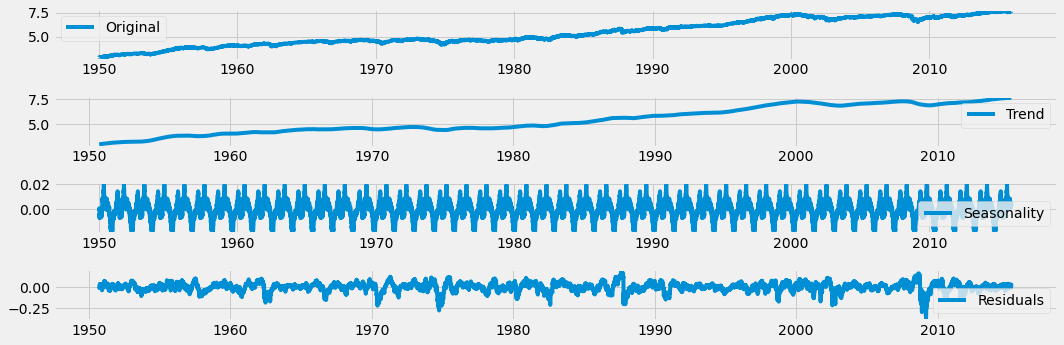

In [15]:
# Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(ts_log,period=365)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.figure(figsize=(15,5))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

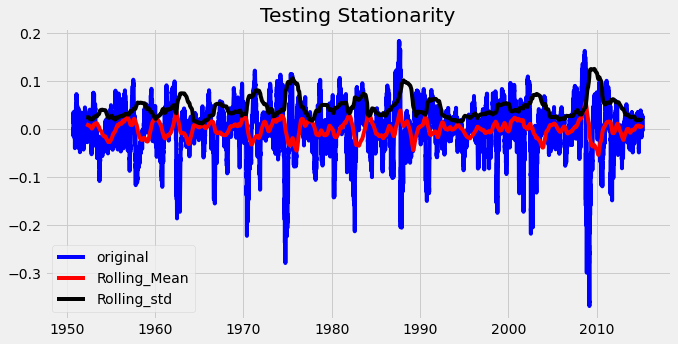

In [16]:
# From the above figure we can see that we have decomposed the time series in its components 
# Now we will be getting rid of trend and seasonality from the model which will leave us only residuals to deal with

ts_log_decompose=residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose,365)


# Forecasting a time series using ARIMA

We have explored various techniques to make the time series stationary. We will be proceeding with the differencing technique since it is very popular and also it will be easier to add back the seasonal and trend components back to the original values.

We will be focusing on ARIMA model for forecasting. ARIMA stands for Auto Regressive Iterative Moving Average model.It is like a linear regression equation and the predictors will depend majorly on three parameters(p,d,q).It majorly has three components:

1. AR(Autoregressive parameter p): Lags of dependent variables.
2. MA(Moving Average parameter q): Lagged forecast errors in prediction equation
3. Differencing parameter(d): Number of non seasonal differences. In our case we took the first order difference.So we can eithe r pass the differenced series and keep this parameter 0 or pass the original series and keeo this parameter 1

The major challenge with building this model is estimating the p and q parameters. For this we will be using the acf and pacf plots.

1. ACF(Autocorrelation Function): Correlation of a ts with lagged version of itself
2. PACF(Partial Autocorrelation Function): Corrleation of a ts with lagged version of itself but after eliminating the intervening variations already explained.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Partial Autocorrelation Function')

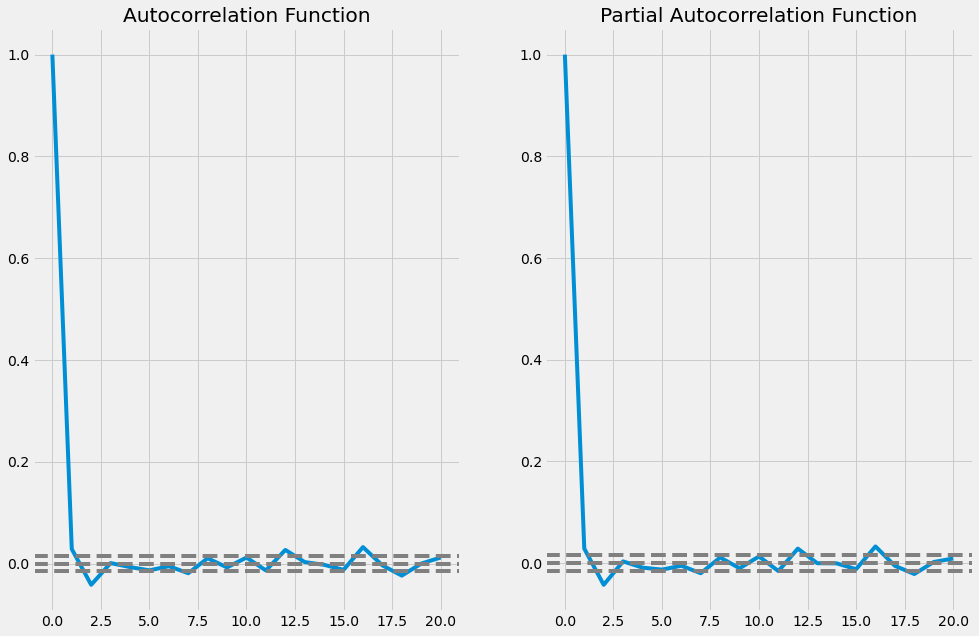

In [17]:
# Plotting acf and pacf

from statsmodels.tsa.stattools import acf,pacf

lag_acf=acf(ts_log_diff,nlags=20)  # nlags is number of lags

lag_pacf=pacf(ts_log_diff,nlags=20,method="ols")

# Plot acf and pacf
#Plot ACF: 
plt.figure(figsize=(15,10))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

## Determing p and q parameters
From the above plots we need to identify the p and q parameters

1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time.Here p=12
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time.Here q=12

# Building the model

Now that we have all the parameters we will be building the ARIMA model with respective values for the parameters.

In [18]:
from statsmodels.tsa.arima.model import ARIMA

ts_log.index = pd.DatetimeIndex(ts_log.index).to_period('D')  # assign Daily Frequency to data.
                                                             #Will convert datetime index to period
ts_model=ARIMA(ts_log,order=(2,1,2))  # since we have passed non differenced series keep d=1

In [19]:
#Forecast using the model
results_ARIMA=ts_model.fit()

In [20]:
fcts=results_ARIMA.forecast(steps=1)

In [22]:
predictions=results_ARIMA.predict(len(ts_log_diff),len(ts_log_diff))

Text(0.5, 1.0, 'RSS: nan')

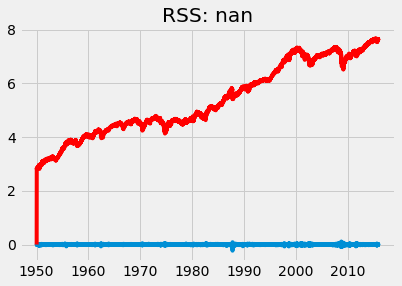

In [23]:
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))